# *Trabajo Práctico N°3*: CNN - CIFAR100

**Cerrato Brown Juan Marcos, Fontecha María Eugenia, Dip Federico**




#Librerías

---
Carga de librerías


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2

from tensorflow.keras.layers import Dense, Flatten, Activation, BatchNormalization, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

from keras.preprocessing import image
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,RandomTranslation,RandomContrast

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


#Carga de datos

---



In [ ]:
%cd /content/drive/My Drive/Redes Neuronales/

!ls

In [ ]:
#Se normalizan las Entradas, se dividen por 255
x_train=np.load("X_train.npy")/255
y_train=np.load("y_train.npy")
x_test=np.load("X_test.npy")/255

In [ ]:
#Dividimos entre train y validación
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

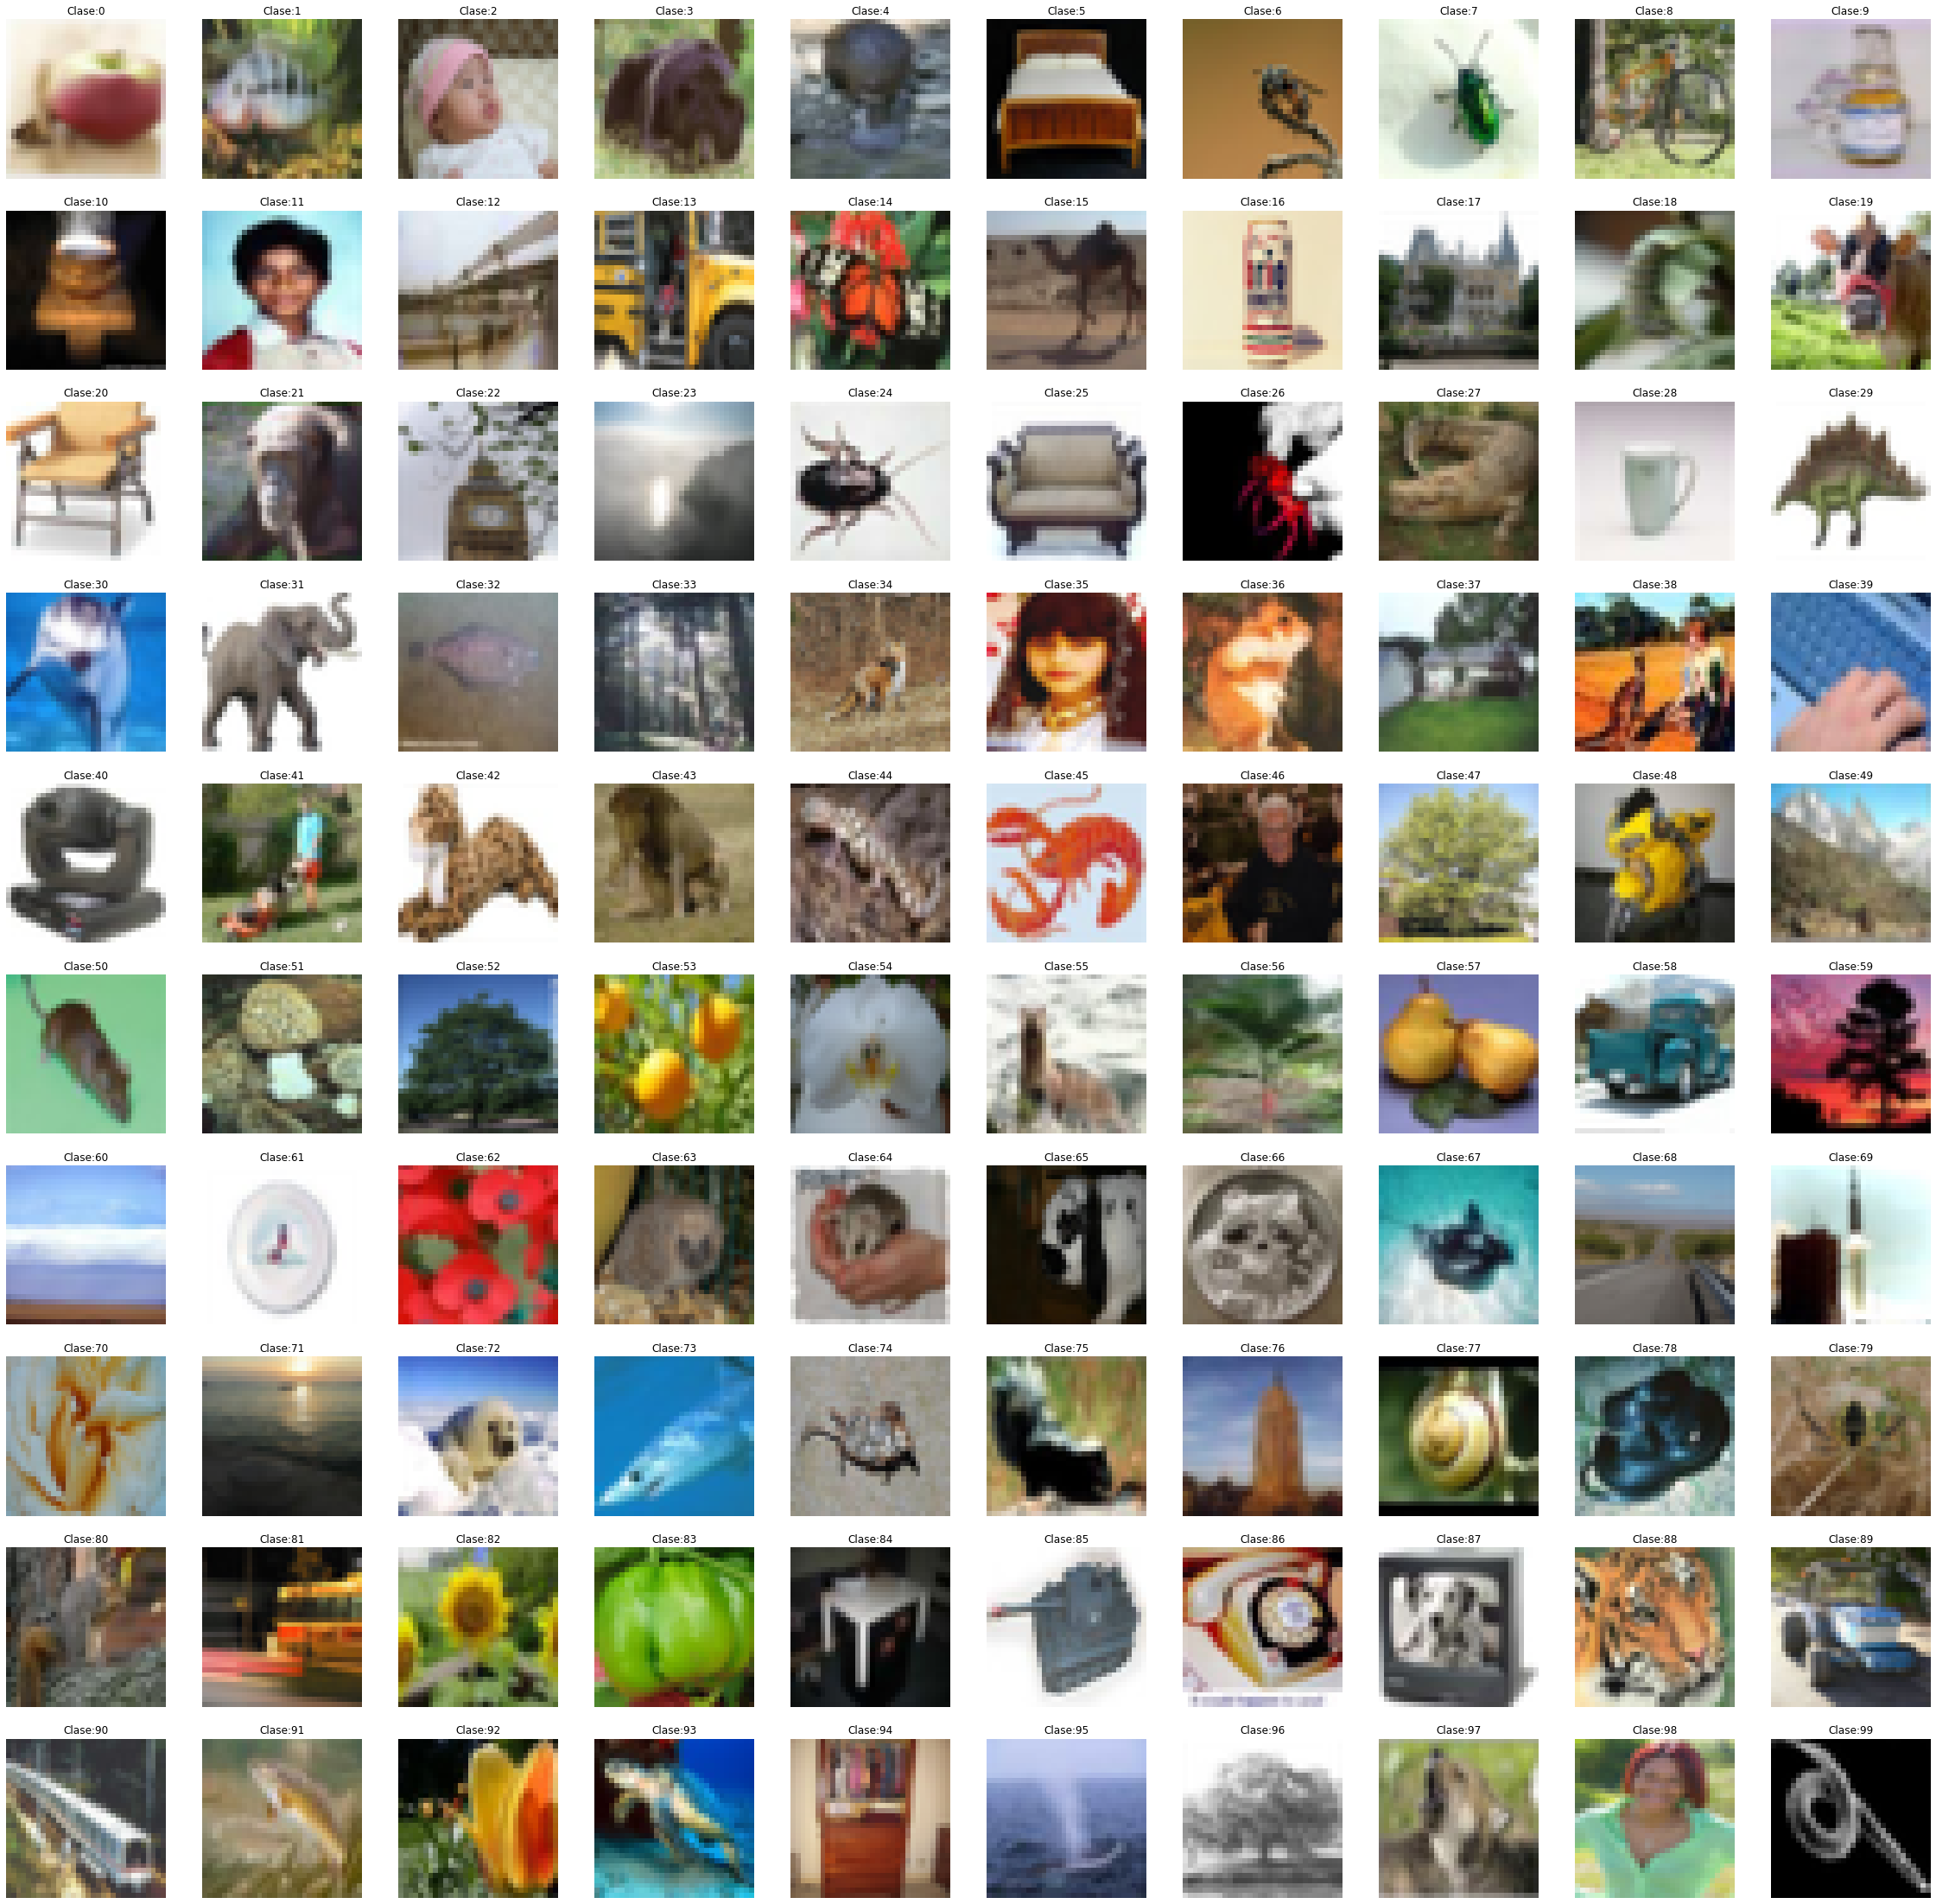

In [ ]:
#Imprimir una imagen de cada clase
fig = plt.figure(figsize=(40, 40))
rows = 10
columns = 10
nro_clases = 100
for i in range(0,nro_clases):
  h = np.where(y_train==i)
  idx = h[0][0]
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(x_train[idx])
  plt.axis('off')
  plt.title("Clase:"+str(i))

In [ ]:
# Imprimir la cantidad de Train, Test, y VAlidation.
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')

42500 train samples
10000 test samples
7500 validation samples


# Modelos
Evaluamos diferentes arquitecteturas con transfer learning y data augmentation:

* VGG16
* EfficientNetB0
* ResNet50
* InceptionResNetV2

## 1- VGG16

### Generamos batches de train y de validación



In [ ]:
datagen = ImageDataGenerator(validation_split=0.1)

train_batches = datagen.flow(
    x_train,
    y_train,
    batch_size=32,
    subset='training',
    )
    

valid_batches = datagen.flow(
    x_train,
    y_train,
    batch_size=32,
    subset='validation',
    )
    

### Data augmentation

In [ ]:
data_augmentation = Sequential([
  RandomFlip('horizontal'),
  RandomRotation(0.2),
])

### Transferencia de aprendizaje (transfer-learning)

In [ ]:
model = Sequential()
model.add(data_augmentation)

conv_base = VGG16(weights="imagenet", 
                  include_top=False,
                  input_shape=(32,32,3))

conv_base.trainable = False
model.add(conv_base)
model.add(Flatten()) #Transformar a tensor 1D
model.add(Dense(256 , activation='relu'))
model.add(Dense(100, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','AUC']) 


In [ ]:
history = model.fit(
          train_batches,#Datos de entrenamiento
          epochs=10, 
          validation_data=valid_batches, #Datos de validacion
          workers=1)

Epoch 1/10
1196/1196 [==============================] - 35s 27ms/step - loss: 3.5029 - accuracy: 0.1764 - auc: 0.8441 - val_loss: 3.1365 - val_accuracy: 0.2233 - val_auc: 0.8864
Epoch 2/10
1196/1196 [==============================] - 31s 26ms/step - loss: 3.0796 - accuracy: 0.2460 - auc: 0.8876 - val_loss: 2.9670 - val_accuracy: 0.2652 - val_auc: 0.8994
Epoch 3/10
1196/1196 [==============================] - 32s 26ms/step - loss: 2.9402 - accuracy: 0.2714 - auc: 0.8992 - val_loss: 2.8973 - val_accuracy: 0.2739 - val_auc: 0.9039
Epoch 4/10
1196/1196 [==============================] - 31s 26ms/step - loss: 2.8592 - accuracy: 0.2862 - auc: 0.9044 - val_loss: 2.8413 - val_accuracy: 0.2887 - val_auc: 0.9061
Epoch 5/10
1196/1196 [==============================] - 31s 26ms/step - loss: 2.7927 - accuracy: 0.2985 - auc: 0.9099 - val_loss: 2.7983 - val_accuracy: 0.2998 - val_auc: 0.9086
Epoch 6/10
1196/1196 [==============================] - 31s 26ms/step - loss: 2.7409 - accuracy: 0.3099 - auc:

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, None, None, None)  0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dense_15 (Dense)            (None, 100)               25700     
                                                                 
Total params: 14,871,716
Trainable params: 157,028
Non-trainable params: 14,714,688
_________________________________________________________________


### Evaluar resultados

In [ ]:
test_batches = datagen.flow(
    x_val,
    y_val,
    batch_size=32,
    )

In [ ]:
test_results = model.evaluate(test_batches)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

235/235 [==============================] - 6s 24ms/step - loss: 2.7902 - accuracy: 0.3107 - auc: 0.9020
Test results - Loss: 2.7902016639709473 - Accuracy: 31.066668033599854%


### Gráficas resultados

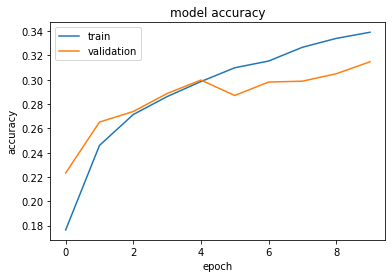

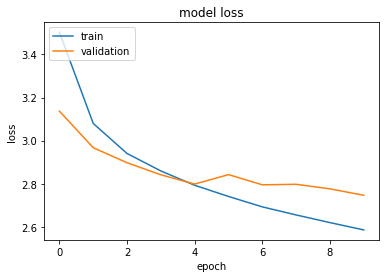

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 2- VGG16
Probamos entrenando el modelo completo

### Inicializamos la red

In [ ]:
preproc=VGG16(include_top = False, pooling = None, weights="imagenet",input_shape=(32,32,3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in preproc.layers:
    layer.trainable=False

### Pasamos los datos por la red VGG16 y guardamos el output.

In [ ]:
x_pre_train=preproc.predict(x_train)
x_pre_valid=preproc.predict(x_valid)

In [ ]:
x_pre_train[0].shape


(1, 1, 512)

### Generamos la red que va a ir después de la VGG. Usamos los outputs anteriores como inputs.

In [ ]:
input_preproc=Input(shape=(1,1,512))

net=Flatten()(input_preproc)

net=Dense(units=256, activation='relu')(net)
net=Dropout(0.2)(net)
net=Dense(units=256, activation='relu')(net)
net=Dropout(0.2)(net)
net=Dense(units=100, activation = 'softmax')(net)

model=Model(input_preproc,net)

model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               25700 

### Contruimos el generador de datos con data augmentation. Y entrenamos el modelo

In [ ]:
train_datagen = ImageDataGenerator(      
        horizontal_flip=True,
        fill_mode='nearest')

epochs = 100
batch_size=64

history =model.fit(train_datagen.flow(x_pre_train,y_train_categorical,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=False), 
                    epochs=epochs, 
                    verbose=1,
                    validation_data=(x_pre_valid, y_val_categorical))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (42500, 1, 1, 512) (512 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/100
665/665 [==============================] - 5s 7ms/step - loss: 4.5515 - accuracy: 0.0275 - val_loss: 4.4239 - val_accuracy: 0.0697
Epoch 2/100
665/665 [==============================] - 4s 6ms/step - loss: 4.3310 - accuracy: 0.0649 - val_loss: 4.1036 - val_accuracy: 0.1151
Epoch 3/100
665/665 [==============================] - 4s 6ms/step - loss: 4.0499 - accuracy: 0.0914 - val_loss: 3.8026 - val_accuracy: 0.1433
Epoch 4/100
665/665 [==============================] - 4s 6ms/step - loss: 3.8299 - accuracy: 0.1141 - val_loss: 3.6108 - val_accuracy: 0.1641
Epoch 5/100
665/665 [==============================] - 4s 6ms/step - loss: 3.6794 - accuracy: 0.1331 - val_loss: 3.4838 - val_accuracy: 0.1835
Epoch 6/100
665/665 [==============================] - 4s 6ms/step - loss: 3.5654 - accuracy: 0.1519 - val_loss: 3.3895 - val_accuracy: 0.1980
Epoch 7/100
665/665 [==============================] - 4s 6ms/step - loss: 3.4855 - accuracy: 0.1646 - val_loss: 3.3202 - val_accuracy: 0.2067

### Unificamos ambas redes en un modelo total

In [ ]:
total_model_output=model(preproc.output)
total_model=Model(preproc.input,total_model_output)
total_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

### Descongelamos los pesos de la VGG.

In [ ]:
for layer in preproc.layers:
    layer.trainable=True
total_model.summary()

total_model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   


### Entrenamos nuevamente y usamos el modelo para predecir las imágenes de test.

Aclaración: no mostramos los resultados ya que esto lo corrimos en kaggle y no se guardaron los outputs.

#### **SUBMISSION**: 0.60800

In [ ]:
batch_size=64
history =total_model.fit(train_datagen.flow(x_train,y_train_categorical,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=False), 
                    epochs=5,
                    verbose=1,
                    validation_data=(x_valid, y_val_categorical))

In [ ]:
y_test_pred=total_model.predict(x_test)

In [ ]:
y_test=y_test_pred.argmax(axis=1)

In [ ]:
df=pd.DataFrame(data=y_test,columns=['label'])
df.index.name="id"

In [ ]:
df.to_csv("submission_VGG.csv")

In [ ]:
idx=2
plt.imshow(x_test[idx])
plt.axis('off')
print(y_test[idx])



## 3- EfficientNetB0

In [ ]:
#no normalizamos entradas porque la efficienteNet toma imágenes de 0 a 255
x_train=np.load("X_train.npy")
y_train=np.load("y_train.npy")
x_test=np.load("X_test.npy")

In [ ]:
#Dividimos entre train y validación (para la validación final)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
#Dividimos entre train y validación (para la validación interna del modelo)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

### Pasamos los datos a tf datasets y modificamos el tamaño de las imágenes


In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
ds_val = tf.data.Dataset.from_tensor_slices((x_val,y_val))
ds_valid = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))

In [ ]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
NUM_CLASSES = 100
size = (IMG_SIZE, IMG_SIZE)
size = (IMG_SIZE, IMG_SIZE)

ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label[0]))
ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size), label[0]))

### Data augmentation

In [ ]:
data_augmentation = Sequential([
  RandomFlip(),
  RandomRotation(0.2),
  RandomTranslation(height_factor=0.1, width_factor=0.1),
  RandomContrast(factor=0.1),
  ],
    name="data_augmentation",
)

### Generamos los batches de train y validación

In [ ]:
batch_size = 64
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(input_preprocess)
ds_val = ds_val.batch(batch_size=batch_size, drop_remainder=True)

### Definimos el modelo
Utilizamos la arquitectura de EfficientNetB0 y hacmeos transfer learning, inicializando los pesos con los de "imagenet". Los freezamos y agregamos una capa de AvgPooling, una de normalización, un dropout de 20% y finalmente una capa de salida de 100 neuronas y función de activación softmax.

In [ ]:
def build_model(num_classes):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

### Entrenamos el modelo con los pesos congelados

In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 18  # @param {type: "slider", min:8, max:80}6
hist = model.fit(ds_train, 
                 epochs=epochs, 
                 validation_data=ds_val, 
                 verbose=2)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

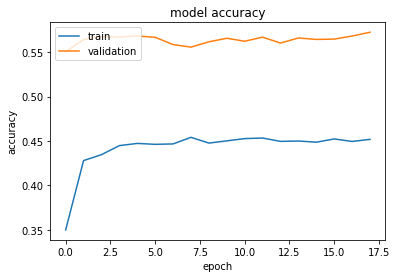

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

### Descongelamos los pesos y volvemos a entrenar el modelo

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


Epoch 1/20
564/564 [==============================] - 194s 326ms/step - loss: 1.8046 - accuracy: 0.5177 - val_loss: 1.2986 - val_accuracy: 0.6398
Epoch 2/20
564/564 [==============================] - 181s 321ms/step - loss: 1.6252 - accuracy: 0.5570 - val_loss: 1.2339 - val_accuracy: 0.6533
Epoch 3/20
564/564 [==============================] - 181s 321ms/step - loss: 1.5066 - accuracy: 0.5779 - val_loss: 1.1839 - val_accuracy: 0.6634
Epoch 4/20
564/564 [==============================] - 181s 321ms/step - loss: 1.4394 - accuracy: 0.5934 - val_loss: 1.1596 - val_accuracy: 0.6760
Epoch 5/20
564/564 [==============================] - 181s 321ms/step - loss: 1.3788 - accuracy: 0.6099 - val_loss: 1.1384 - val_accuracy: 0.6791
Epoch 6/20
564/564 [==============================] - 181s 321ms/step - loss: 1.3191 - accuracy: 0.6245 - val_loss: 1.1188 - val_accuracy: 0.6823
Epoch 7/20
564/564 [==============================] - 184s 326ms/step - loss: 1.2791 - accuracy: 0.6348 - val_loss: 1.1064 -

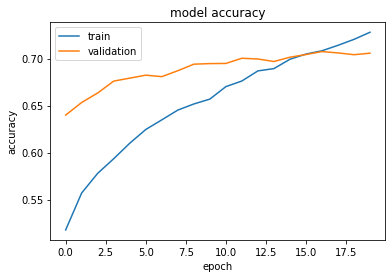

In [ ]:
unfreeze_model(model)

epochs = 20  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train,
                 epochs=epochs, 
                 validation_data=ds_val, 
                 verbose=1)
plot_hist(hist)

Vemos que en las últimas épocas ya estamos teniendo overfitting

### Evaluamos resultados

In [ ]:
ds_valid = ds_valid.map(lambda image, label: (tf.image.resize(image, size), label[0]))
ds_valid = ds_valid.map(input_preprocess)
ds_valid = ds_valid.batch(batch_size=batch_size, drop_remainder=False)
test_results = model.evaluate(ds_valid)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

Tensor("args_1:0", shape=(), dtype=int64)
Tensor("args_0:0", shape=(224, 224, 3), dtype=float32)
118/118 [==============================] - 32s 247ms/step - loss: 1.0578 - accuracy: 0.6959
Test results - Loss: 1.057808518409729 - Accuracy: 69.58666443824768%


### Predecimos test

In [ ]:
ds_test = tf.data.Dataset.from_tensor_slices(x_test)
ds_test = ds_test.map(lambda image: tf.image.resize(image, size))

#batches
#hace falta el batch? no lo sé.... podemos probar con y sin batch
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=False)
test_results = model.predict(ds_test)

In [ ]:
y_test=test_results.argmax(axis=1)
df=pd.DataFrame(data=y_test,columns=['label'])
df.index.name="id"
df.to_csv("submission_EfficentNet.csv")

#### **SUBMISSION**: 0.715

## 4- ResNet50

### Convertimos los datos en datasets de tf y modificamos el tamaño de las imágenes

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
ds_val = tf.data.Dataset.from_tensor_slices((x_val,y_val))
ds_valid = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))

In [ ]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
NUM_CLASSES = 100
size = (IMG_SIZE, IMG_SIZE)
size = (IMG_SIZE, IMG_SIZE)

ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label[0]))
ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size), label[0]))

### Definimos el data augmentation

In [ ]:
data_augmentation = Sequential([
  RandomFlip(),
  RandomRotation(0.2),
  RandomTranslation(height_factor=0.1, width_factor=0.1),
  RandomContrast(factor=0.1)
  ],
    name="data_augmentation",
)

### Categorizamos las clases y generamos batches de datos

In [ ]:
batch_size = 64
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(input_preprocess)
ds_val = ds_val.batch(batch_size=batch_size, drop_remainder=True)

### Construimos el modelo

Inicializamos los pesos según los de imagenet y los congelamos

In [ ]:
def build_model(num_classes):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    model = ResNet50(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.3
    x = Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

### Realizamos el primer entrenamiento

In [ ]:
# Callbacks
checkpoint_file='checkpoint.cifar100-cnn-TL-RN-1.hdf5'
checkpointer1 = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 5  # @param {type: "slider", min:5, max:80}
hist = model.fit(ds_train, 
                 epochs=epochs, 
                 validation_data=ds_val, 
                 verbose=1,
                 callbacks = [checkpointer1])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


632/632 [==============================] - 301s 450ms/step - loss: 3.3417 - accuracy: 0.3700 - val_loss: 1.5214 - val_accuracy: 0.5790
Epoch 2/5
632/632 [==============================] - ETA: 0s - loss: 2.0348 - accuracy: 0.4641
Epoch 00002: val_accuracy did not improve from 0.57902
632/632 [==============================] - 278s 439ms/step - loss: 2.0348 - accuracy: 0.4641 - val_loss: 1.5628 - val_accuracy: 0.5786
Epoch 3/5
632/632 [==============================] - ETA: 0s - loss: 2.0200 - accuracy: 0.4674
Epoch 00003: val_accuracy improved from 0.57902 to 0.58080, saving model to checkpoint.cifar100-cnn-TL-RN-1.hdf5
632/632 [==============================] - 285s 450ms/step - loss: 2.0200 - accuracy: 0.4674 - val_loss: 1.5530 - val_accuracy: 0.5808
Epoch 4/5
632/632 [==============================] - ETA: 0s - loss: 2.0388 - accuracy: 0.4692
Epoch 00004: val_accuracy did not improve from 0.58080
632/632 [==============================] - 277s 438ms/step - loss: 2.0388 - accuracy: 0

### Descongelamos los pesos y volvemos a entrenar

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(
        optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"]
    )


In [ ]:
# Callbacks
checkpoint_file='checkpoint.cifar100-cnn-TL-RN-2.hdf5'
checkpointer2 = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [ ]:
#cargamos los mejores pesos del checkpoint 1
model.load_weights('checkpoint.cifar100-cnn-TL-RN-1.hdf5')
unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:5, max:50}
hist = model.fit(ds_train,
                 epochs=epochs, 
                 validation_data=ds_val, 
                 verbose=1,
                 callbacks = [checkpointer2])

Epoch 1/10
632/632 [==============================] - ETA: 0s - loss: 1.6851 - accuracy: 0.5351
Epoch 00001: val_accuracy improved from -inf to 0.63103, saving model to checkpoint.cifar100-cnn-TL-RN-2.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


632/632 [==============================] - 319s 491ms/step - loss: 1.6851 - accuracy: 0.5351 - val_loss: 1.2967 - val_accuracy: 0.6310
Epoch 2/10
632/632 [==============================] - ETA: 0s - loss: 1.5235 - accuracy: 0.5728
Epoch 00002: val_accuracy improved from 0.63103 to 0.64866, saving model to checkpoint.cifar100-cnn-TL-RN-2.hdf5
632/632 [==============================] - 322s 509ms/step - loss: 1.5235 - accuracy: 0.5728 - val_loss: 1.2348 - val_accuracy: 0.6487
Epoch 3/10
632/632 [==============================] - ETA: 0s - loss: 1.4245 - accuracy: 0.5985
Epoch 00003: val_accuracy improved from 0.64866 to 0.66004, saving model to checkpoint.cifar100-cnn-TL-RN-2.hdf5
632/632 [==============================] - 309s 488ms/step - loss: 1.4245 - accuracy: 0.5985 - val_loss: 1.1875 - val_accuracy: 0.6600
Epoch 4/10
632/632 [==============================] - ETA: 0s - loss: 1.3568 - accuracy: 0.6129
Epoch 00004: val_accuracy improved from 0.66004 to 0.66585, saving model to check

NameError: ignored

In [ ]:
rlrop_patience = 5
decay_rate = 0.5

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-5, verbose = 1)

In [ ]:
#cargamos los mejores pesos del checkpoint 1
model.load_weights('checkpoint.cifar100-cnn-TL-RN-2.hdf5')

epochs = 10  # @param {type: "slider", min:5, max:50}
hist = model.fit(ds_train,
                 epochs=epochs, 
                 validation_data=ds_val, 
                 verbose=1,
                 callbacks = [checkpointer2,earlystop,rlrop])

Epoch 1/10
632/632 [==============================] - ETA: 0s - loss: 1.0237 - accuracy: 0.6985
Epoch 00001: val_accuracy did not improve from 0.69911
632/632 [==============================] - 315s 487ms/step - loss: 1.0237 - accuracy: 0.6985 - val_loss: 1.0423 - val_accuracy: 0.6989 - lr: 0.0100
Epoch 2/10
632/632 [==============================] - ETA: 0s - loss: 0.9910 - accuracy: 0.7067
Epoch 00002: val_accuracy improved from 0.69911 to 0.70446, saving model to checkpoint.cifar100-cnn-TL-RN-2.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


632/632 [==============================] - 319s 504ms/step - loss: 0.9910 - accuracy: 0.7067 - val_loss: 1.0420 - val_accuracy: 0.7045 - lr: 0.0100
Epoch 3/10
632/632 [==============================] - ETA: 0s - loss: 0.9559 - accuracy: 0.7131
Epoch 00003: val_accuracy did not improve from 0.70446
632/632 [==============================] - 306s 485ms/step - loss: 0.9559 - accuracy: 0.7131 - val_loss: 1.0346 - val_accuracy: 0.7027 - lr: 0.0100
Epoch 4/10
632/632 [==============================] - ETA: 0s - loss: 0.9251 - accuracy: 0.7223
Epoch 00004: val_accuracy improved from 0.70446 to 0.70737, saving model to checkpoint.cifar100-cnn-TL-RN-2.hdf5
632/632 [==============================] - 308s 488ms/step - loss: 0.9251 - accuracy: 0.7223 - val_loss: 1.0329 - val_accuracy: 0.7074 - lr: 0.0100
Epoch 5/10
632/632 [==============================] - ETA: 0s - loss: 0.8962 - accuracy: 0.7315
Epoch 00005: val_accuracy did not improve from 0.70737
632/632 [==============================] - 31

In [ ]:
rlrop_patience = 5
decay_rate = 0.5

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-5, verbose = 1)

In [ ]:
#cargamos los mejores pesos del checkpoint 1
model.load_weights('checkpoint.cifar100-cnn-TL-RN-2.hdf5')

epochs = 10  # @param {type: "slider", min:5, max:50}
hist = model.fit(ds_train,
                 epochs=epochs, 
                 validation_data=ds_val, 
                 verbose=1,
                 callbacks = [checkpointer2,earlystop,rlrop])

Epoch 1/10
632/632 [==============================] - ETA: 0s - loss: 1.0237 - accuracy: 0.6985
Epoch 00001: val_accuracy did not improve from 0.69911
632/632 [==============================] - 315s 487ms/step - loss: 1.0237 - accuracy: 0.6985 - val_loss: 1.0423 - val_accuracy: 0.6989 - lr: 0.0100
Epoch 2/10
632/632 [==============================] - ETA: 0s - loss: 0.9910 - accuracy: 0.7067
Epoch 00002: val_accuracy improved from 0.69911 to 0.70446, saving model to checkpoint.cifar100-cnn-TL-RN-2.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


632/632 [==============================] - 319s 504ms/step - loss: 0.9910 - accuracy: 0.7067 - val_loss: 1.0420 - val_accuracy: 0.7045 - lr: 0.0100
Epoch 3/10
632/632 [==============================] - ETA: 0s - loss: 0.9559 - accuracy: 0.7131
Epoch 00003: val_accuracy did not improve from 0.70446
632/632 [==============================] - 306s 485ms/step - loss: 0.9559 - accuracy: 0.7131 - val_loss: 1.0346 - val_accuracy: 0.7027 - lr: 0.0100
Epoch 4/10
632/632 [==============================] - ETA: 0s - loss: 0.9251 - accuracy: 0.7223
Epoch 00004: val_accuracy improved from 0.70446 to 0.70737, saving model to checkpoint.cifar100-cnn-TL-RN-2.hdf5
632/632 [==============================] - 308s 488ms/step - loss: 0.9251 - accuracy: 0.7223 - val_loss: 1.0329 - val_accuracy: 0.7074 - lr: 0.0100
Epoch 5/10
632/632 [==============================] - ETA: 0s - loss: 0.8962 - accuracy: 0.7315
Epoch 00005: val_accuracy did not improve from 0.70737
632/632 [==============================] - 31

In [ ]:
epochs = 5  # @param {type: "slider", min:5, max:50}
hist = model.fit(ds_train,
                 epochs=epochs, 
                 validation_data=ds_val, 
                 verbose=1,
                 callbacks = [checkpointer2,earlystop,rlrop])

Epoch 1/5
632/632 [==============================] - ETA: 0s - loss: 0.7279 - accuracy: 0.7778
Epoch 00001: val_accuracy did not improve from 0.71451
632/632 [==============================] - 306s 484ms/step - loss: 0.7279 - accuracy: 0.7778 - val_loss: 1.0365 - val_accuracy: 0.7112 - lr: 0.0100
Epoch 2/5
632/632 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.7817
Epoch 00002: val_accuracy improved from 0.71451 to 0.71652, saving model to checkpoint.cifar100-cnn-TL-RN-2.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


632/632 [==============================] - 307s 486ms/step - loss: 0.7103 - accuracy: 0.7817 - val_loss: 1.0229 - val_accuracy: 0.7165 - lr: 0.0100
Epoch 3/5
632/632 [==============================] - ETA: 0s - loss: 0.6783 - accuracy: 0.7900
Epoch 00003: val_accuracy did not improve from 0.71652
632/632 [==============================] - 306s 483ms/step - loss: 0.6783 - accuracy: 0.7900 - val_loss: 1.0363 - val_accuracy: 0.7098 - lr: 0.0100
Epoch 4/5
632/632 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.7912
Epoch 00004: val_accuracy did not improve from 0.71652
632/632 [==============================] - 317s 501ms/step - loss: 0.6698 - accuracy: 0.7912 - val_loss: 1.0287 - val_accuracy: 0.7129 - lr: 0.0100
Epoch 5/5
632/632 [==============================] - ETA: 0s - loss: 0.6427 - accuracy: 0.8000
Epoch 00005: val_accuracy did not improve from 0.71652
632/632 [==============================] - 318s 503ms/step - loss: 0.6427 - accuracy: 0.8000 - val_loss: 1

### Calculamos accuracy en validación

In [ ]:
ds_valid = ds_valid.map(lambda image, label: (tf.image.resize(image, size), label[0]))
ds_valid = ds_valid.map(input_preprocess)
ds_valid = ds_valid.batch(batch_size=batch_size, drop_remainder=False)
model.load_weights('checkpoint.cifar100-cnn-TL-RN-2.hdf5')
test_results = model.evaluate(ds_valid)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

79/79 [==============================] - 33s 378ms/step - loss: 0.9944 - accuracy: 0.7172
Test results - Loss: 0.9943867921829224 - Accuracy: 71.7199981212616%


### Predecimos test

In [ ]:
ds_test = tf.data.Dataset.from_tensor_slices(x_test)
def input_preprocess(image):    
    image = tf.keras.applications.resnet.preprocess_input(image)
    return image
ds_test = ds_test.map(lambda image: tf.image.resize(image, size))
ds_test = ds_test.map(input_preprocess)

#batches

ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=False)
test_predict = model.predict(ds_test)


In [ ]:
y_test=test_predict.argmax(axis=1)
df=pd.DataFrame(data=y_test,columns=['label'])
df.index.name="id"
df.to_csv("submission_ResNet50.csv")

#### **SUBMISSION**: 0.713

## 5 - InceptionResNetV2

### Pasamos los datos a tf datasets y modificamos el tamaño de las imágenes


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
ds_val = tf.data.Dataset.from_tensor_slices((x_val,y_val))
ds_valid = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))

In [ ]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 299
NUM_CLASSES = 100
size = (IMG_SIZE, IMG_SIZE)
size = (IMG_SIZE, IMG_SIZE)

ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label[0]))
ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size), label[0]))

### Data augmentation

In [ ]:
data_augmentation = Sequential([
  RandomFlip(),
  RandomRotation(0.2),
  RandomTranslation(height_factor=0.1, width_factor=0.1),
  RandomContrast(factor=0.1)
  ],
    name="data_augmentation",
)

### Generamos los batches de train y validación

In [ ]:
batch_size = 64
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(input_preprocess)
ds_val = ds_val.batch(batch_size=batch_size, drop_remainder=True)

### Definimos el modelo
Utilizamos la arquitectura de InceptionResNetV2 y hacemos transfer learning, inicializando los pesos con los de "imagenet". Los freezamos y agregamos una capa de AvgPooling, una de normalización, un dropout de 30% y finalmente una capa de salida de 100 neuronas y función de activación softmax.

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

def build_model(num_classes):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    model = InceptionResNetV2(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output) #maxpooling
    x = BatchNormalization()(x)

    top_dropout_rate = 0.3
    x = Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

### Realizamos el primer entrenamiento

In [ ]:
# Callbacks
checkpoint_file='checkpoint.cifar100-cnn-TL-IRNV2-1.hdf5'
checkpointer1 = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 5  # @param {type: "slider", min:5, max:80}
hist = model.fit(ds_train, 
                epochs=epochs, 
                validation_data=ds_val, 
                verbose=1,
                callbacks = [checkpointer1])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

### Descongelamos los pesos y volvemos a entrenar

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(
        optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"]
    )


In [ ]:
# Callbacks
checkpoint_file='checkpoint.cifar100-cnn-TL-IRNV2-2.hdf5'
checkpointer2 = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [ ]:
#cargamos los mejores pesos del checkpoint 1
model.load_weights('checkpoint.cifar100-cnn-TL-IRNV2-1.hdf5')
unfreeze_model(model)

epochs = 5  # @param {type: "slider", min:5, max:50}
hist = model.fit(ds_train,
                 epochs=epochs, 
                 validation_data=ds_val, 
                 verbose=1,
                 callbacks = [checkpointer2])
plot_hist(hist)

Epoch 1/5
632/632 [==============================] - ETA: 0s - loss: 1.7846 - accuracy: 0.5141
Epoch 00001: val_accuracy improved from -inf to 0.65692, saving model to checkpoint.cifar100-cnn-TL-IRNV2-2.hdf5
632/632 [==============================] - 1084s 2s/step - loss: 1.7846 - accuracy: 0.5141 - val_loss: 1.1899 - val_accuracy: 0.6569
Epoch 2/5
632/632 [==============================] - ETA: 0s - loss: 1.6901 - accuracy: 0.5363
Epoch 00002: val_accuracy improved from 0.65692 to 0.67188, saving model to checkpoint.cifar100-cnn-TL-IRNV2-2.hdf5
632/632 [==============================] - 1054s 2s/step - loss: 1.6901 - accuracy: 0.5363 - val_loss: 1.1540 - val_accuracy: 0.6719
Epoch 3/5
632/632 [==============================] - ETA: 0s - loss: 1.6163 - accuracy: 0.5542
Epoch 00003: val_accuracy improved from 0.67188 to 0.67857, saving model to checkpoint.cifar100-cnn-TL-IRNV2-2.hdf5
632/632 [==============================] - 1064s 2s/step - loss: 1.6163 - accuracy: 0.5542 - val_loss: 1

NameError: ignored

In [ ]:
rlrop_patience = 5
decay_rate = 0.5

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-5, verbose = 1)

In [ ]:
#cargamos los mejores pesos
model.load_weights('checkpoint.cifar100-cnn-TL-IRNV2-2.hdf5')

epochs = 5  # @param {type: "slider", min:5, max:50}
hist = model.fit(ds_train,
                 epochs=epochs, 
                 validation_data=ds_val, 
                 verbose=1,
                 callbacks = [checkpointer2,earlystop,rlrop])

Epoch 1/5
632/632 [==============================] - ETA: 0s - loss: 1.4816 - accuracy: 0.5825
Epoch 00001: val_accuracy did not improve from 0.69129
632/632 [==============================] - 1065s 2s/step - loss: 1.4816 - accuracy: 0.5825 - val_loss: 1.0840 - val_accuracy: 0.6882 - lr: 0.0100
Epoch 2/5
632/632 [==============================] - ETA: 0s - loss: 1.4424 - accuracy: 0.5955
Epoch 00002: val_accuracy improved from 0.69129 to 0.69643, saving model to checkpoint.cifar100-cnn-TL-IRNV2-2.hdf5
632/632 [==============================] - 1046s 2s/step - loss: 1.4424 - accuracy: 0.5955 - val_loss: 1.0441 - val_accuracy: 0.6964 - lr: 0.0100
Epoch 3/5
632/632 [==============================] - ETA: 0s - loss: 1.4182 - accuracy: 0.6015
Epoch 00003: val_accuracy improved from 0.69643 to 0.70268, saving model to checkpoint.cifar100-cnn-TL-IRNV2-2.hdf5
632/632 [==============================] - 1048s 2s/step - loss: 1.4182 - accuracy: 0.6015 - val_loss: 1.0315 - val_accuracy: 0.7027 - l

# Conclusión

Luego de haber probado entrenar diferentes modelos con transfer learning y data augmentation para el set de datos de CIFAR, vemos que el que mejor resultados obtuvo fue el de la arquitectura de EfficientNetB0.